In [29]:
#%%
"""         Chem 210A/B --  C.W. McCurdy -- January 2021
   
 Read a file with potential curve values and find bound states 
              for particle with specified mass

 Finite Element Method - Discrete Variable Representation (FEM-DVR) 
 for 1D Schroedinger equation using Gauss-Lobatto quadrature in each finite element
 Uses class DVRHelper() to construct FEM-DVR points, weights and Kinetic Energy

 Shows how to 
   (1) Read in and interpolate a potential function known at discrete points
       using cubic spline interpretation
   (2) Use DVRHelper class to build FEM-DVR grid
   (3) Use DVRHelper class to build Hamiltonian in DVR basis
   (4) Find eigenvalues and eigenvectors of Hamiltonian
   (5) Plot eigenfunctions of the Hamiltonian

 Example: Harmonic Oscillator with potential specified at 25 points in x
          on the interval -5 bohr to + 5 bohr.   Solved using a mass of an 
          H atom using a DVR on -2 to 2 bohr.

 Student Exercise: 
          H2 vibrational states using CI singles and doubles potential curve
          from Psi4 provided at 500 input points.
          This potential yields a n = 0 -> 1 excitation energy 
          within a few wavenumbers of the value using the NIST values for
          constants of diatomic molecules for H2 in the formula
           E_n = (n+1/2)we - (n+1/2)^2 wexe, which is 4158 cm^-1

"""
#%%
# preliminaries to invoke SciPy linear algebra functions 
from scipy import linalg as LA
# and NumPy which is used to define pi, sqrt, array, .transpose etc. as np
import numpy as np
from scipy.interpolate import CubicSpline  
import matplotlib.pyplot as plt  # import matplotlib pyplot functions
from matplotlib import animation  # for animation from same class library
import os  # functions to manipulate files and directories
from DVR.DVRHelper import DVRHelper  # contains Barbalinardo/McCurdy FEM-DVR and Crank Nicolson functions
import time as timeclock  # for timing parts of the calculation during debugging
from datascience import*
%matplotlib inline 
plt.style.use('fast')
#
#============== Make Directory for Plots if it's not there already ==========
#  
# detect the current working directory and print it
path = os.getcwd()  
print ("The current working directory is %s" % path)  
# define the name of the directory to be created
Plot_Output = path+'/Plot_Output'
if os.path.exists(Plot_Output):
    print("Directory for wave function plots already exists",Plot_Output)
else:
    print("Attempting to create directory for wave function plots ",Plot_Output)
    try:  
        os.mkdir(Plot_Output)
    except OSError:  
        print ("Creation of the directory %s failed" % Plot_Output)
    else:  
        print ("Successfully created the directory %s " % Plot_Output)
#
#=== Make Directory for for the .dat output  if it's not there already ======
#  
# detect the current working directory and print it
path = os.getcwd()  
print ("The current working directory is %s" % path)  
# define the name of the directory to be created
Data_Output = path+'/Data_Output'
if os.path.exists(Data_Output):
    print("Directory for output .dat files  already exists",Plot_Output)
else:
    print("Attempting to create directory for .dat output files  ",Plot_Output)
    try:  
        os.mkdir(Data_Output)
    except OSError:  
        print ("Creation of the directory %s failed" % Data_Output)
    else:  
        print ("Successfully created the directory %s " % Data_Output)
# ===================================================================
wfcn_plotfile=open("Data_Output/wavefunctions.dat","w") # data file for saving wavefunctions
#
#=============Constants and conversion factors ==============
Daltons_to_eMass = 1822.89
bohr_to_Angstrom = 0.529177
Hartree_to_eV = 27.211386245988 # NIST ref
eV_to_wavennumber = 8065.54393734921 # NIST ref on constants + conversions 
Hartree_to_wavenumber = 2.1947463136320e5    # value from NIST ref on constants + conversions
atu_to_fs = 24.18884326509/1000
HartreeToKelvin = 315773;
#

The current working directory is C:\Users\Delilahs PC\Downloads
Directory for wave function plots already exists C:\Users\Delilahs PC\Downloads/Plot_Output
The current working directory is C:\Users\Delilahs PC\Downloads
Directory for output .dat files  already exists C:\Users\Delilahs PC\Downloads/Plot_Output


In [30]:
#=====================================FEM_DVR===================================
#  Set up the FEM DVR grid given only the Finite Element boundaries and order
#  of Gauss Lobatto quadrature,  and compute the Kinetic Energy matrix for 
#  this FEM DVR for Mass = mass set in call (atomic units).
#
# Here is where the reduced mass (or mass for any 1D problem) is set 
#He_Mass = 4.0026 
#O_Mass =  15.99491461957 # O 16 mass from NIST tables
a = 1/1.0277
re = 1.4022
De = 0.1746
#H_Mass = (1.007825032*1.007825032)/(1.007825032+1.007825032) #H atom atomic mass
#H_Mass = 1
mu = 1835.2395 # Convert mass to atomic units (mass of the electron)
n_order = 30  # order of the DVR in each finite element is set here
               # routines work for quadrature orders up to at least 150
#FEM_boundaries = [0.2,5,10,20,30]

In [31]:
a

0.9730466089325678

In [32]:
FEM_boundaries = np.linspace(0,15,300)
dvr = DVRHelper(n_order, FEM_boundaries,Mass=mu)
print("\nFEM-DVR basis of ", dvr.nbas, " functions")
#
#   Function to define potential at x and t (if potential is time-dependent)
#   DVRHelper class library expects function for V(x,t) in general
#


From FEM_DVR_build: building grid and KE with Gauss Lobatto quadrature of order  30
element  1  xmin =  0.0  xmax =  0.05016722408026756
element  2  xmin =  0.05016722408026756  xmax =  0.10033444816053512
element  3  xmin =  0.10033444816053512  xmax =  0.1505016722408027
element  4  xmin =  0.1505016722408027  xmax =  0.20066889632107024
element  5  xmin =  0.20066889632107024  xmax =  0.2508361204013378
element  6  xmin =  0.2508361204013378  xmax =  0.3010033444816054
element  7  xmin =  0.3010033444816054  xmax =  0.3511705685618729
element  8  xmin =  0.3511705685618729  xmax =  0.4013377926421405
element  9  xmin =  0.4013377926421405  xmax =  0.45150501672240806
element  10  xmin =  0.45150501672240806  xmax =  0.5016722408026756
element  11  xmin =  0.5016722408026756  xmax =  0.5518394648829431
element  12  xmin =  0.5518394648829431  xmax =  0.6020066889632107
element  13  xmin =  0.6020066889632107  xmax =  0.6521739130434783
element  14  xmin =  0.6521739130434783  xmax =


FEM-DVR basis of  8670  functions


In [33]:
# =================================Potential=====================================

In [34]:
def Morse (r,time):
    pot = De * (np.exp(-2*a*(r-re)) - 2*np.exp(-1*a*(r-re)) )
    return pot

In [35]:
Morse_pot = []
for i in FEM_boundaries:
    pot = De * (np.exp(-2*a*((i)-re)) - np.exp(-1*a*((i)-re)) )
    Morse_pot.append(pot)

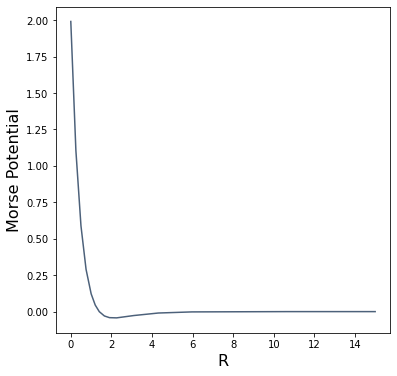

In [36]:
Table().with_columns("R",FEM_boundaries,"Morse Potential",Morse_pot).plot(0)

In [37]:
# vectorized version of potential routine to be used in calls to Hamiltonian 
# speeds up time-dependent calculations where it is called many times
Morse_vectorized = np.vectorize(Morse)


In [38]:
#
# =============Build Hamiltonian (using general routine with dummy time t=0)=========
#     Pass name of potential function explicitly here
time = 0.0
H_mat = dvr.Hamiltonian(Morse_vectorized, time)
print("\n Completed construction of Hamiltonian ")
#====================================================================================
#
# Find all the eigenvalues of the Hamiltonian so we can compare with known bound state energies
# or make a plot of the spectrum -- For a time-independent Hamiltonian example here
#
EigenVals = LA.eigvalsh(H_mat)
#
n_energy = 30 
print("\n            Lowest ", n_energy,"   Eigenvalues of the DVR Hamiltonian \n")
for  i in range(0,n_energy):
     print("E( ",i,") =   ",EigenVals[i]," hartrees, excitation energy = ",(EigenVals[i]-EigenVals[0])* Hartree_to_wavenumber," cm^-1")
#====================================================================================
#
# Extract the n_Plot'th eigenfunction for plotting and use as initial wave function
# to test propagation
#
number_of_eigenvectors = n_energy 
#
#  Here n_Plot picks which eigenfunction to plot
n_Plot = 0  # pick a state of this potential to plot < number_of_eigenvectors -1
#
print("Calculating ",number_of_eigenvectors," eigenvectors for plotting eigenfunctions")
EigenVals, EigenVecs  = LA.eigh(H_mat,eigvals=(0,number_of_eigenvectors))
wfcnPlot = []
for j in range(0,dvr.nbas):
    wfcnPlot.append(EigenVecs[j,n_Plot])
#


 Completed construction of Hamiltonian 

            Lowest  30    Eigenvalues of the DVR Hamiltonian 

E(  0 ) =    -0.1679533783114059  hartrees, excitation energy =  0.0  cm^-1
E(  1 ) =    -0.15504706796441642  hartrees, excitation energy =  2832.6077056645677  cm^-1
E(  2 ) =    -0.14265666832133664  hartrees, excitation energy =  5551.986099772227  cm^-1
E(  3 ) =    -0.1307821793816134  hartrees, excitation energy =  8158.135182444379  cm^-1
E(  4 ) =    -0.11942360114777081  hartrees, excitation energy =  10651.05495312705  cm^-1
E(  5 ) =    -0.10858093361739446  hartrees, excitation energy =  13030.745412350137  cm^-1
E(  6 ) =    -0.09825417679183358  hartrees, excitation energy =  15297.20655981752  cm^-1
E(  7 ) =    -0.08844333067038047  hartrees, excitation energy =  17450.438395684523  cm^-1
E(  8 ) =    -0.07914839525367887  hartrees, excitation energy =  19490.44091980986  cm^-1
E(  9 ) =    -0.07036937054071289  hartrees, excitation energy =  21417.214132416488  cm^

In [39]:
(0-10, 24)
print(0.0070160158353155-De)

-0.1675839841646845



 Plot wave function  0  (numbered in order of increasing energy)

 Running from terminal, close figure window to proceed and make .pdf file of figure


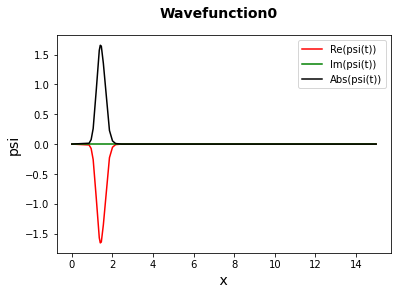

In [40]:
#================# Plot the  wave function specified by n_Plot above======================
#   It must be type np.complex for this general wave function plotting logic
#
Cinitial  = np.zeros((dvr.nbas), dtype=complex) 
wfcnInitialPlot  = np.zeros((dvr.nbas), dtype=complex) 
for j in range(0,dvr.nbas):
   Cinitial[j] = wfcnPlot[j]
#
print("\n Plot wave function ",n_Plot," (numbered in order of increasing energy)")
title = 'Wavefunction'+str(n_Plot)
#  note that the dvr.Plot_Psi function makes a .pdf file in the Plot_Output directory
#  That's what make_plot=True controls.  
x_Plot_array, Psi_plot_array = dvr.Plot_Psi(Cinitial, plot_title_string=title,N_plot_points=len(FEM_boundaries),make_plot=True)
# write the data in file also
for j in range(0,len(FEM_boundaries)):
    print(FEM_boundaries,"  ",np.real(FEM_boundaries),"  ",np.imag(FEM_boundaries),file=wfcn_plotfile)
print("&  \n ",file=wfcn_plotfile)
#